In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


100%|██████████| 9.91M/9.91M [00:00<00:00, 19.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 465kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.1MB/s]

Device: cuda


In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_shape=(1,28,28)):
        super().__init__()
        self.img_shape = img_shape
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, int(torch.prod(torch.tensor(img_shape)))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(z.size(0), *self.img_shape)

class Discriminator(nn.Module):
    def __init__(self, img_shape=(1,28,28)):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(int(torch.prod(torch.tensor(img_shape))), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img.view(img.size(0), -1))

latent_dim = 100
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)


In [ ]:
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)


In [ ]:
import numpy as np

epochs = 5
for epoch in range(epochs):
    for imgs, _ in train_loader:
        batch_size = imgs.size(0)
        real_imgs = imgs.to(device)

        # Adversarial ground truths
        valid = torch.ones(batch_size,1).to(device)
        fake = torch.zeros(batch_size,1).to(device)

        # -----------------
        # Train Generator
        # -----------------
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # -----------------
        # Train Discriminator
        # -----------------
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss)/2
        d_loss.backward()
        optimizer_D.step()

    print(f"Epoch {epoch+1}/{epochs}, D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")


Epoch 1/5, D_loss: 1.2438, G_loss: 0.7751
Epoch 2/5, D_loss: 0.2585, G_loss: 1.6580
Epoch 3/5, D_loss: 0.0814, G_loss: 2.2103
Epoch 4/5, D_loss: 0.4017, G_loss: 1.5207
Epoch 5/5, D_loss: 0.1216, G_loss: 3.0433


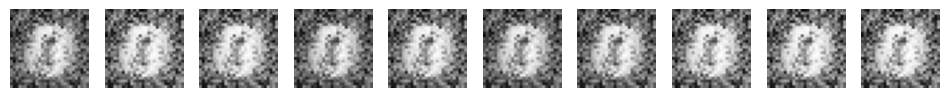

In [ ]:
import matplotlib.pyplot as plt

generator.eval()
with torch.no_grad():
    z = torch.randn(10, latent_dim).to(device)
    gen_imgs = generator(z)

plt.figure(figsize=(12,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(gen_imgs[i].cpu().squeeze(), cmap='gray')
    plt.axis('off')
plt.show()
